## Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision


In [2]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


Load the `MNIST` dataset and normalize the images between -1 and 1 as this makes the implementation easier.

In [3]:
def prepare_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    trainset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    testset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainloader, testloader

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The Langevin dynamics in our case starts with a randomly initialized $x_0$ and then uses the information about the landscape of the energy function
(i.e., the gradient) to seek for new $x$, that is:
$$x_{t+1} = x_{t} + \alpha \nabla_{x_t}\text{LogSumExp} \left[f_{\theta} (x) \right] + \sigma \cdot \epsilon$$

where $\alpha, \sigma > 0$ and $\epsilon \sim \mathcal{N}(0, I)$. The Langevin dynamics could be seen as the stochastic gradient descent in the observable space with a small Gaussian noise added at each step.

Our goal is to run the Langevin dynamics for $\eta$ iterations with the steps size $\alpha$ and the noise level equal $\sigma$.

In [5]:
import torch

def energy_gradient(model, x):
    model.eval()
    x = x.clone().detach().requires_grad_(True)
    output = torch.logsumexp(model(x), dim=1).sum()
    output.backward()
    grad = x.grad.clone()
    model.train()
    return grad

In [6]:
def langevin_dynamics_step(model, x, alpha, sigma):
    x = x.detach().requires_grad_()
    logits = model(x)
    energy = torch.logsumexp(logits / 10, dim=1).sum()
    grad = torch.autograd.grad(energy, x, create_graph=True)[0]
    x = x + alpha * grad + sigma * torch.randn_like(x)
    x = torch.clamp(x, -1, 1)  # Keep values within valid range
    return x

def langevin_dynamics(model, x, eta, alpha, sigma):
    for _ in range(eta):
        x = langevin_dynamics_step(model, x, alpha, sigma)
    return x.detach()

# Sampling

In [7]:
def sample(model, eta, alpha, sigma, input_shape):
    x = torch.rand((1, *input_shape)) * 2 - 1
    x = x.to(next(model.parameters()).device)
    for _ in range(eta):
        x = langevin_dynamics_step(model, x, alpha, sigma)
    return x

We can evaluate our model using the following objective:

$$\mathcal{L} = \mathcal{L}_\text{clf}(\theta) + \mathcal{L}_\text{gen}(\theta)$$

Where $\mathcal{L}_\text{clf}(\theta)$ is the cross-entropy loss and $\mathcal{L}_\text{gen}(\theta)$ is an approximation to the log-marginal distribution over images (for example the LogSumExp loss).

# Neural Network 

In [8]:
def loss_function(model, x, y, eta, alpha, sigma):
    # Discriminative Loss
    logits = model(x)
    discriminative_loss = F.cross_entropy(logits, y)

    # Generative Loss
    x_sampled = torch.rand_like(x) * 2 - 1  
    x_sampled = langevin_dynamics(model, x_sampled, eta, alpha, sigma)
    energy_real = torch.logsumexp(model(x) / 10, dim=1).mean()
    energy_fake = torch.logsumexp(model(x_sampled) / 10, dim=1).mean()
    generative_loss = - (energy_real - energy_fake)

    # Combine Losses
    total_loss = discriminative_loss + 0.1 * generative_loss
    return total_loss

Define the neural network that specifies the energy function.
The inputs should be images and the outputs must be the classes.
Don't forget to use appropriate activation functions!

In [9]:
class EnergyNet(nn.Module):
    def __init__(self):
        super(EnergyNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits


Create the following functions to be able to visualize real and generated images.

In [10]:
def visualize_real(loader):
    images, _ = next(iter(loader))
    images = images[:16]
    grid = torchvision.utils.make_grid(images, nrow=4, normalize=True, pad_value=1)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.title("Real Images")
    plt.axis('off')
    plt.show()

def visualize_generated(model, eta, alpha, sigma):
    device = next(model.parameters()).device
    x_sample = torch.rand((16, 1, 28, 28), device=device) * 2 - 1
    x_sample = langevin_dynamics(model, x_sample, eta, alpha, sigma)
    grid = torchvision.utils.make_grid(x_sample, nrow=4, normalize=True, pad_value=1)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.title("Generated Images")
    plt.axis('off')
    plt.show()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 58208254.22it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1690422.74it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 14277733.52it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 13617247.15it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




Epoch 1/20: 100%|██████████| 938/938 [01:38<00:00,  9.52it/s, loss=-17.9]


Epoch 1: Avg Loss = -14.5333


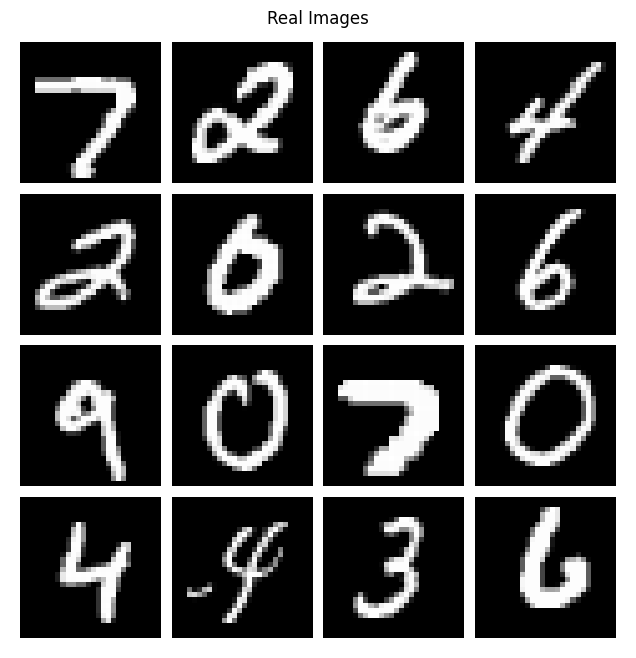

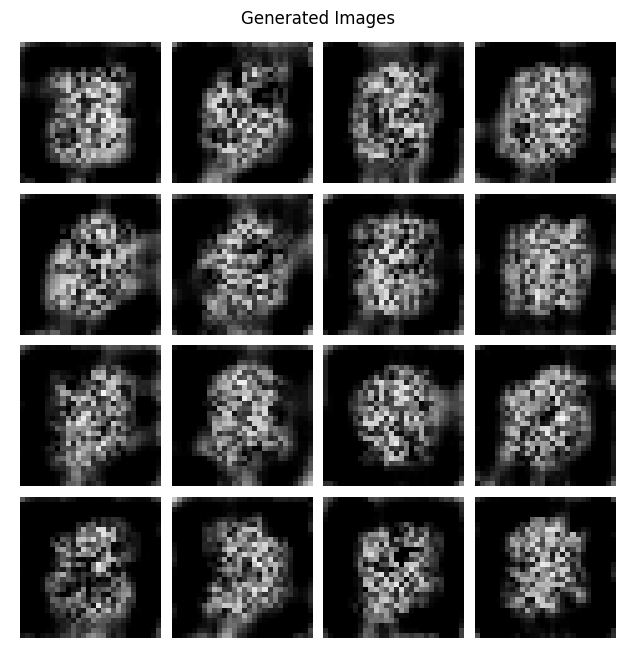

Epoch 2/20: 100%|██████████| 938/938 [01:37<00:00,  9.64it/s, loss=-17.6]


Epoch 2: Avg Loss = -22.9870


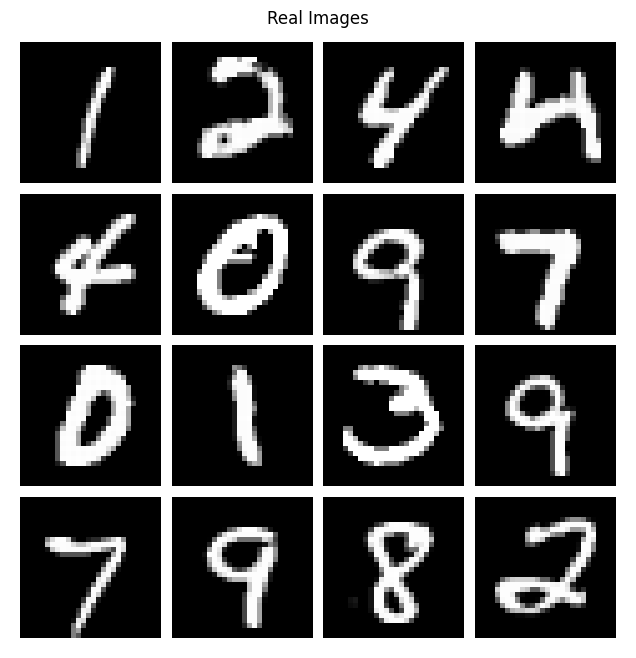

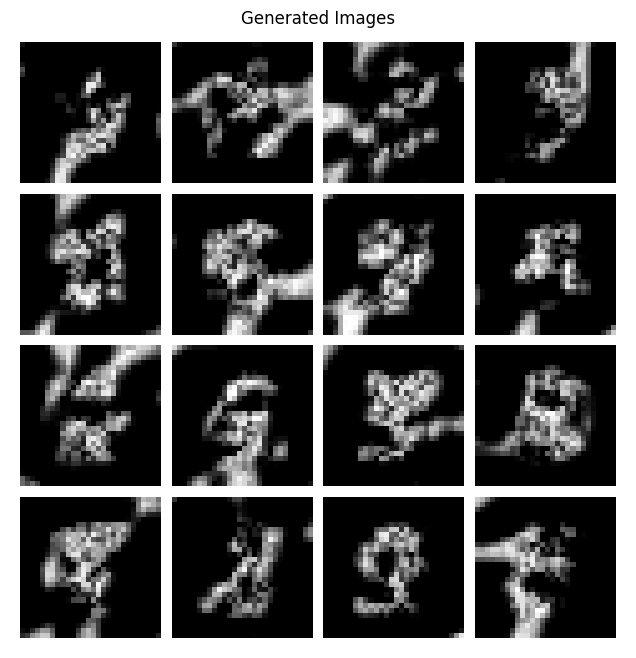

Epoch 3/20: 100%|██████████| 938/938 [01:37<00:00,  9.64it/s, loss=0.718]


Epoch 3: Avg Loss = -12.4475


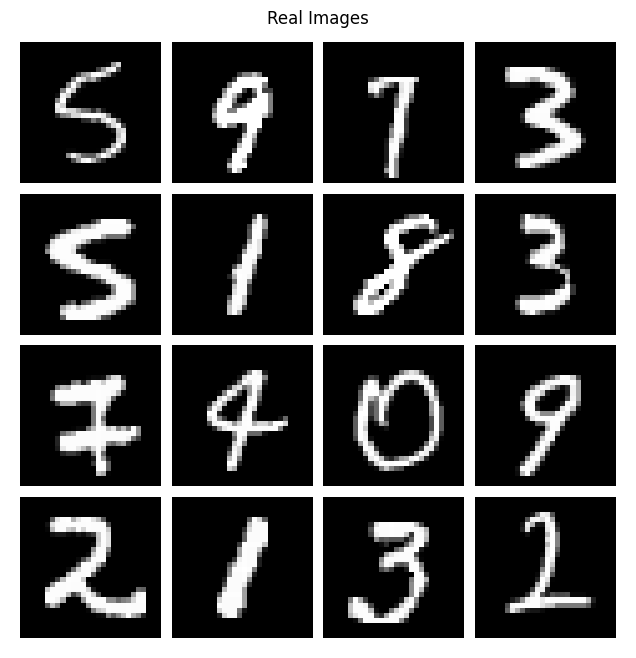

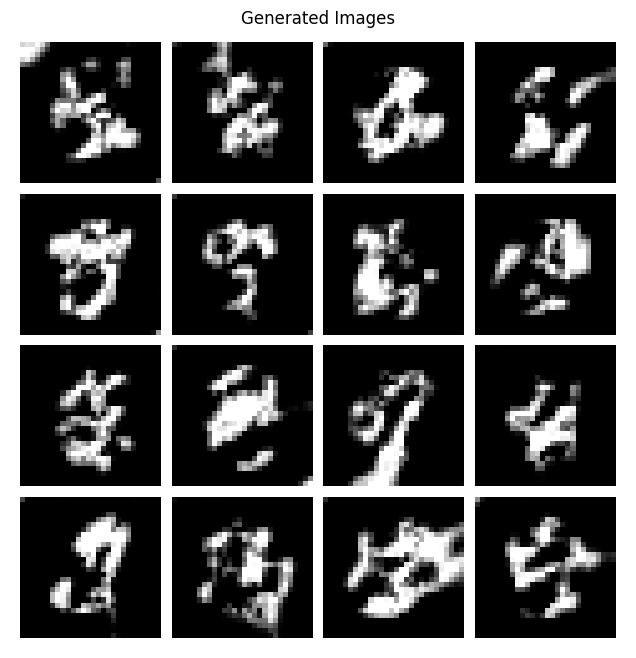

Epoch 4/20: 100%|██████████| 938/938 [01:37<00:00,  9.63it/s, loss=-7.57]


Epoch 4: Avg Loss = -7.4770


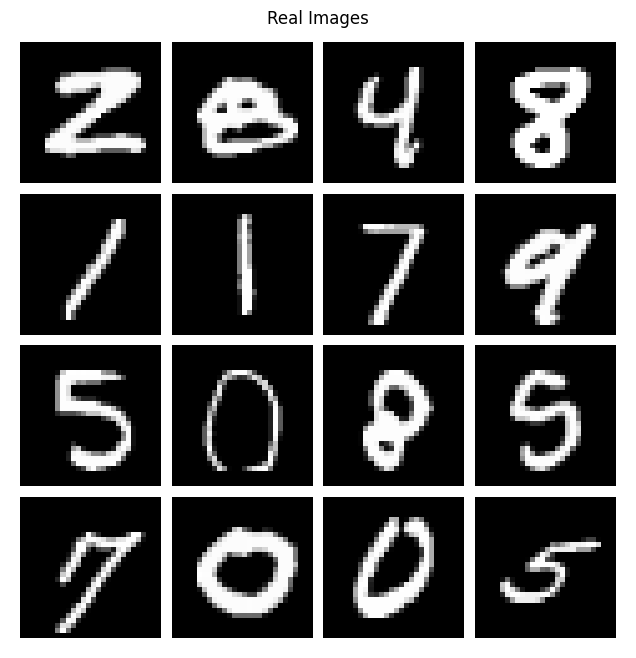

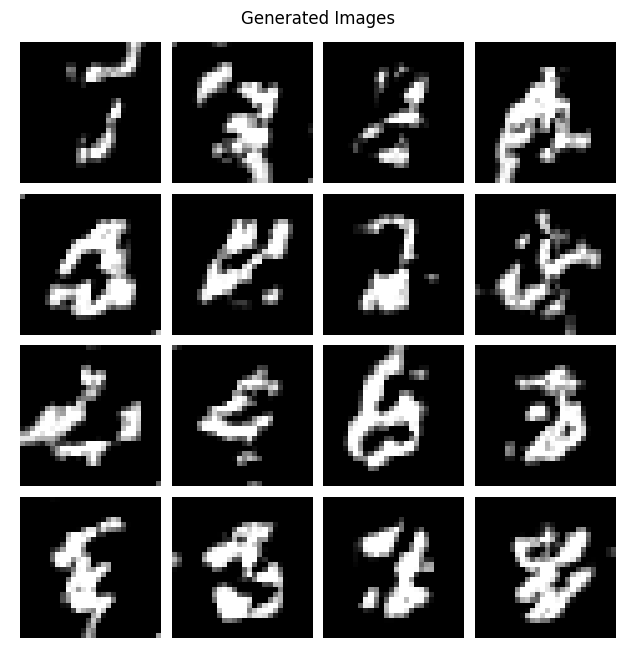

Epoch 5/20: 100%|██████████| 938/938 [01:37<00:00,  9.63it/s, loss=-7.09]


Epoch 5: Avg Loss = -5.9300


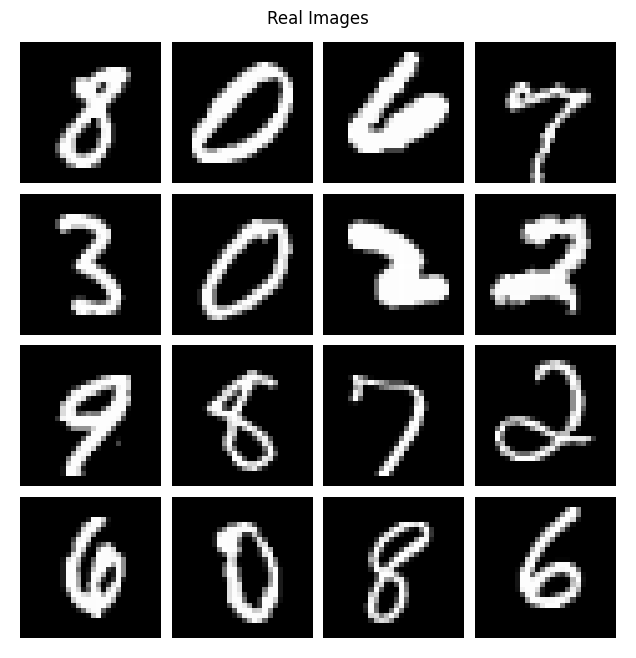

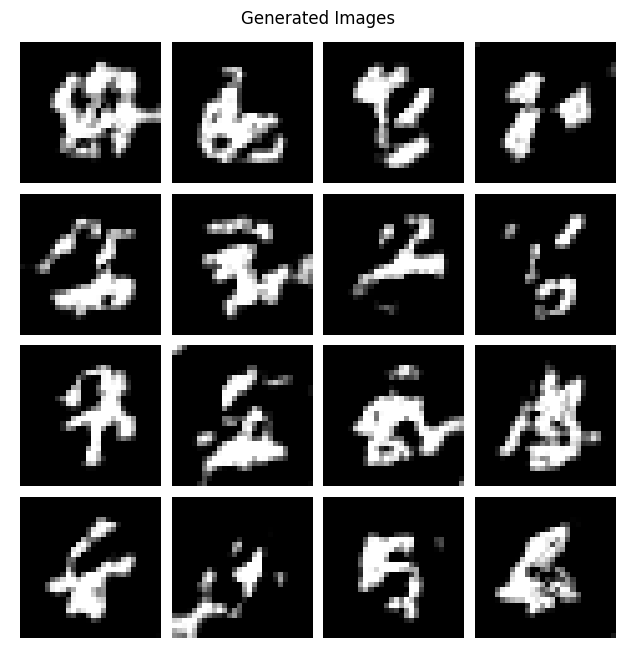

Epoch 6/20: 100%|██████████| 938/938 [01:37<00:00,  9.63it/s, loss=-8.85]


Epoch 6: Avg Loss = -5.0694


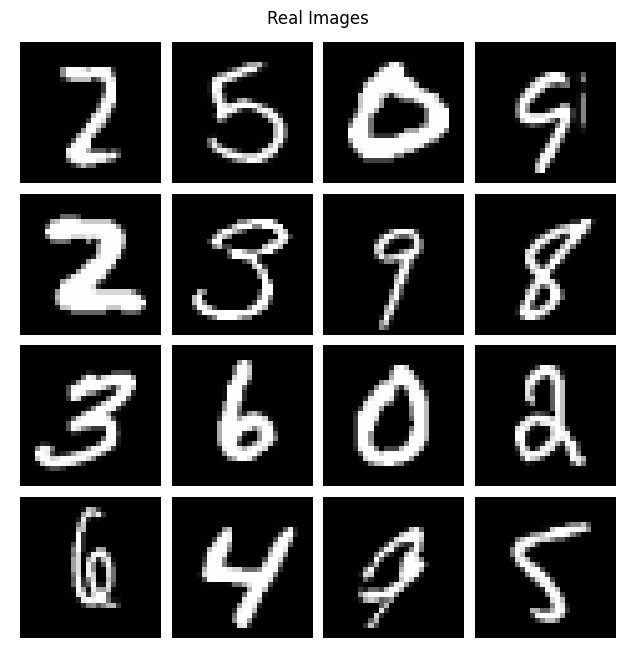

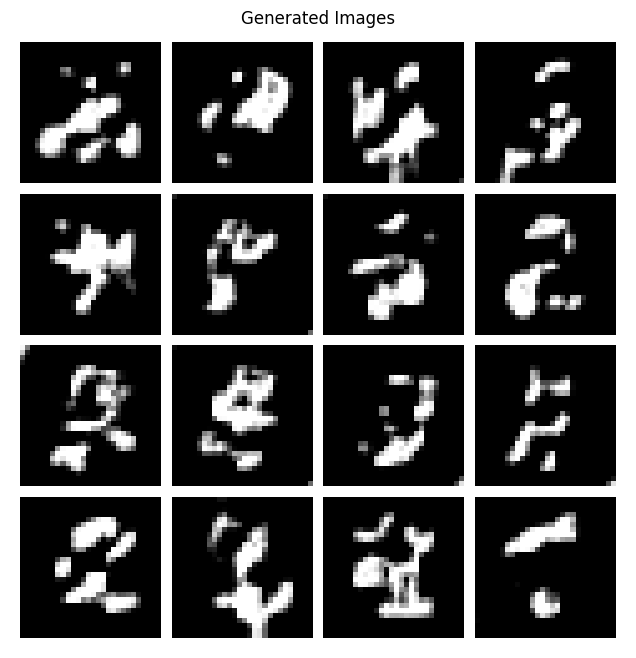

Epoch 7/20: 100%|██████████| 938/938 [01:37<00:00,  9.63it/s, loss=-12.4]


Epoch 7: Avg Loss = -4.7009


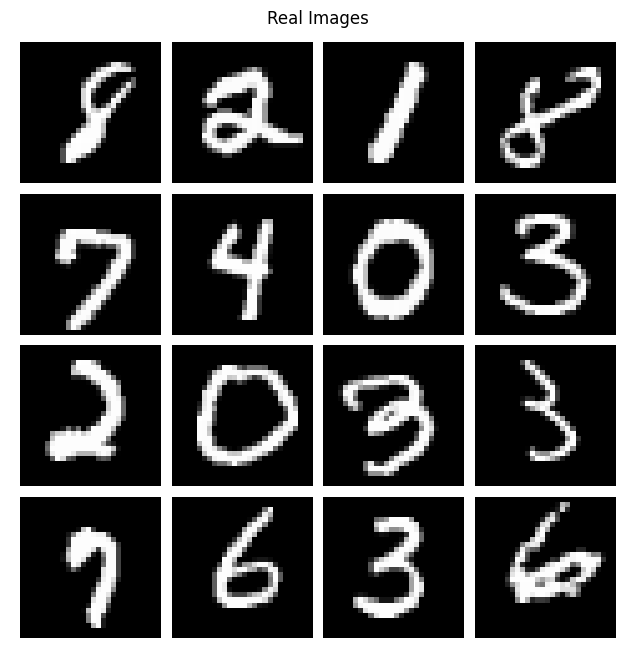

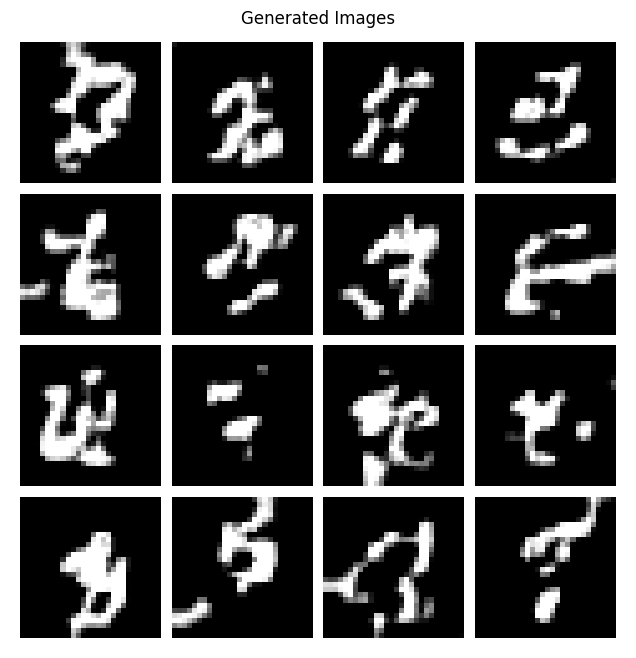

Epoch 8/20: 100%|██████████| 938/938 [01:37<00:00,  9.62it/s, loss=-2.02]


Epoch 8: Avg Loss = -4.3633


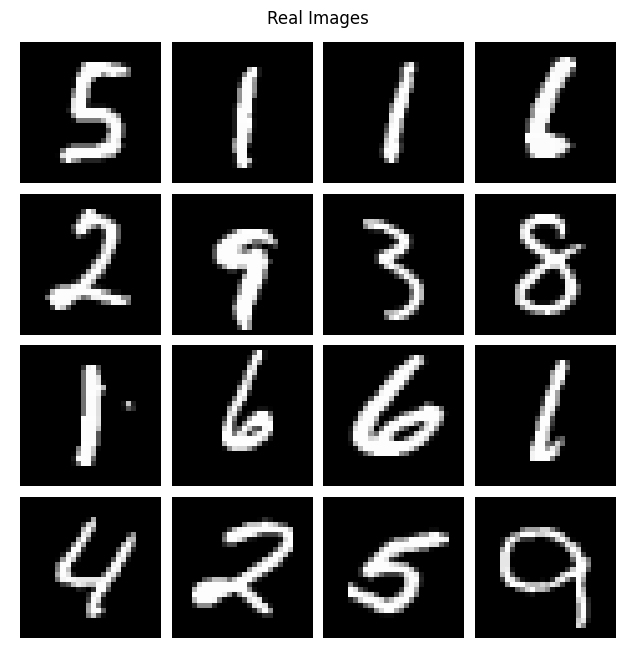

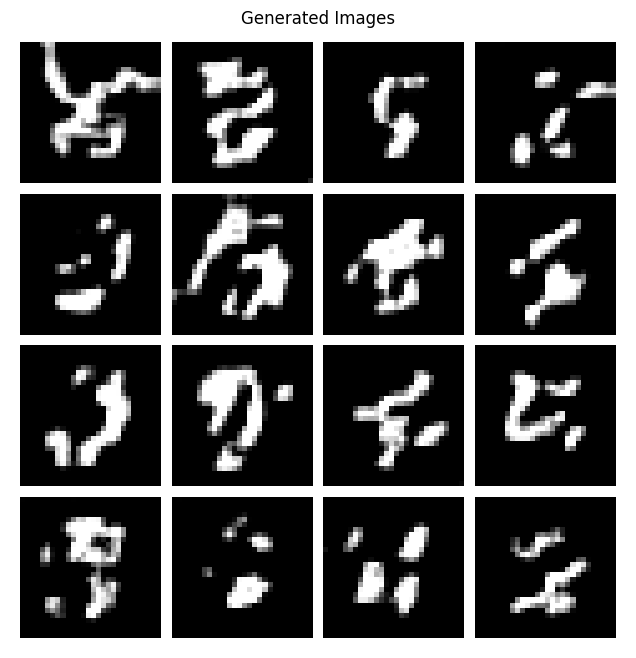

Epoch 9/20: 100%|██████████| 938/938 [01:37<00:00,  9.63it/s, loss=-3.46]


Epoch 9: Avg Loss = -3.9275


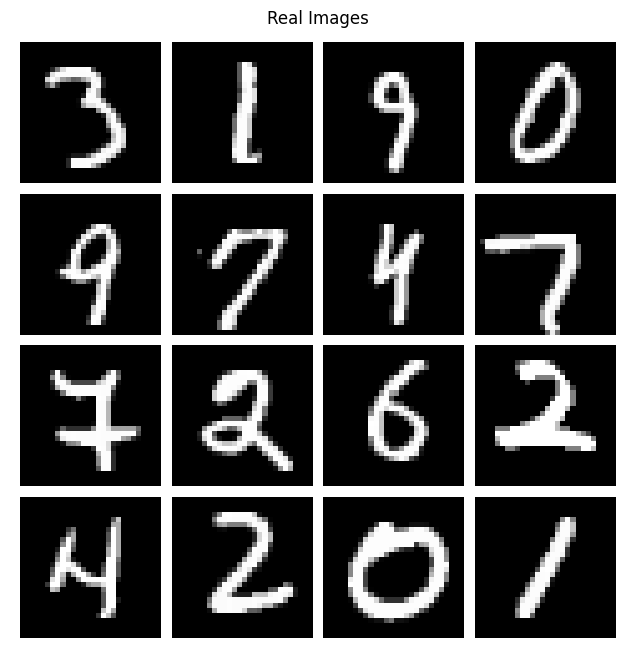

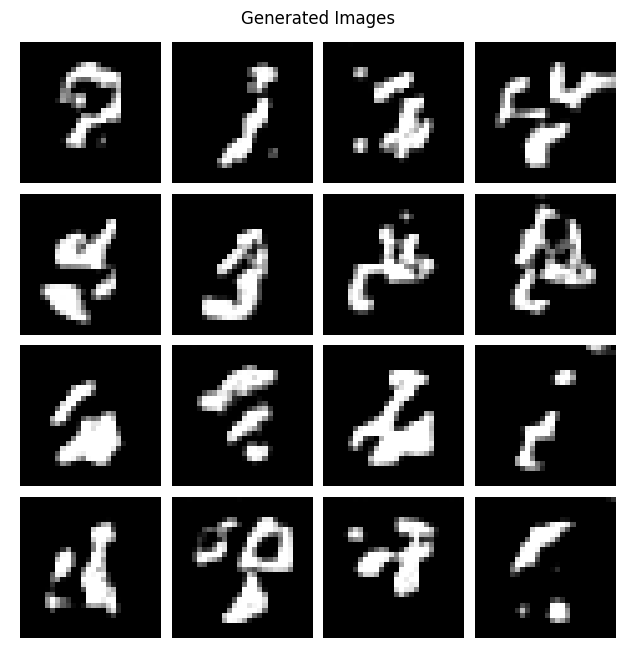

Epoch 10/20: 100%|██████████| 938/938 [01:37<00:00,  9.64it/s, loss=-1.18]


Epoch 10: Avg Loss = -3.7752


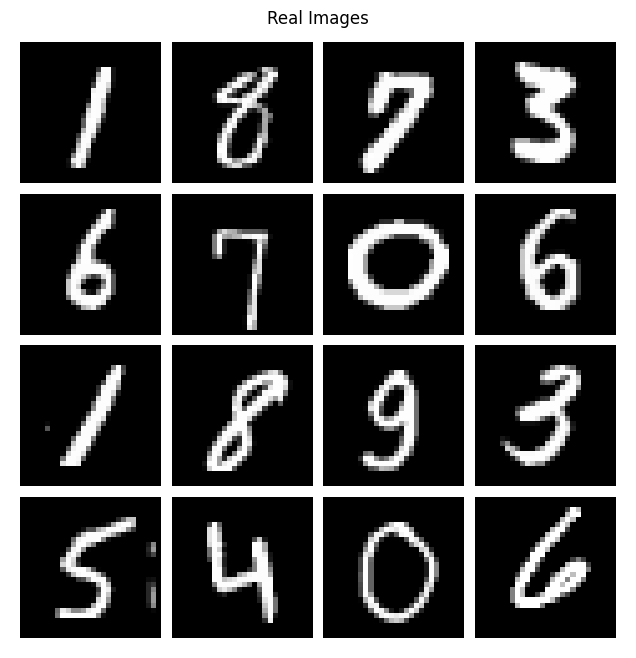

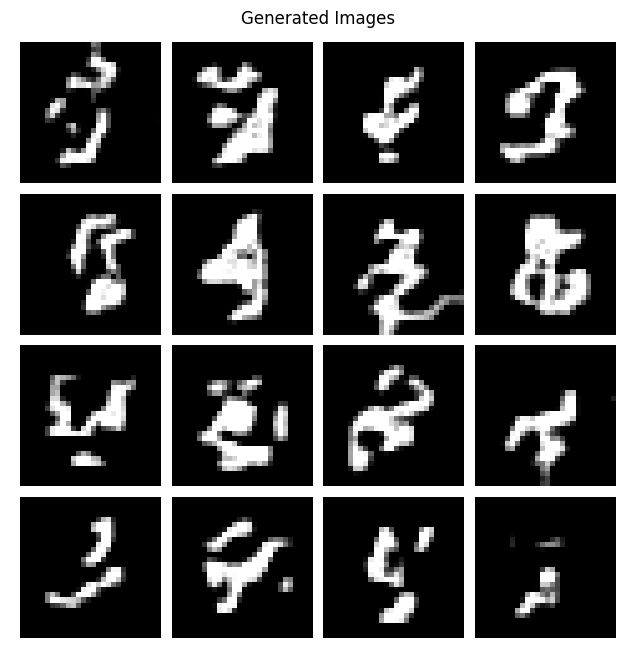

Epoch 11/20: 100%|██████████| 938/938 [01:37<00:00,  9.63it/s, loss=4.26]


Epoch 11: Avg Loss = -3.9617


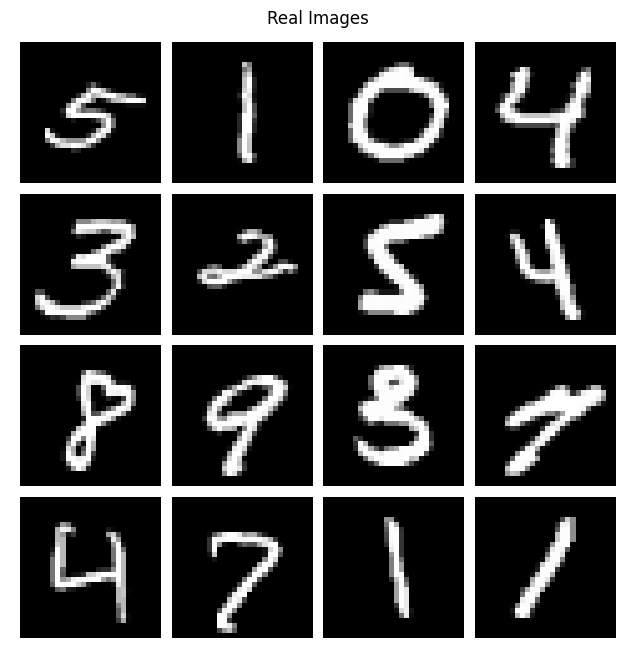

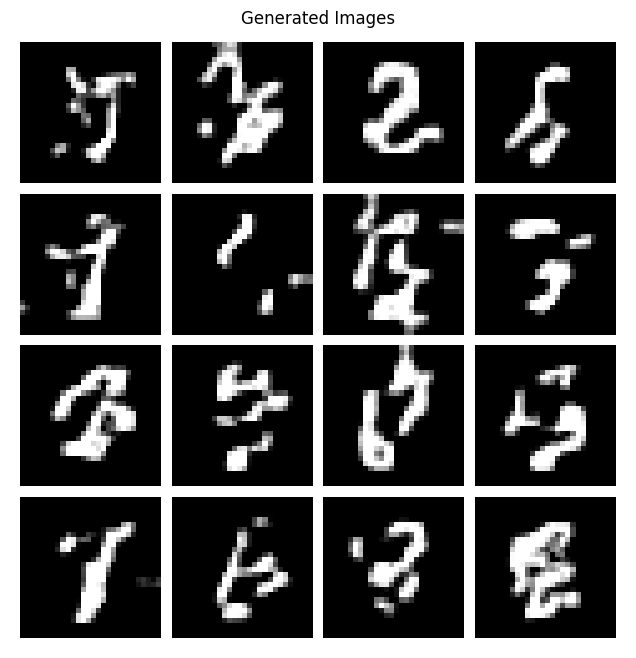

Epoch 12/20: 100%|██████████| 938/938 [01:37<00:00,  9.64it/s, loss=-13.7]


Epoch 12: Avg Loss = -3.9690


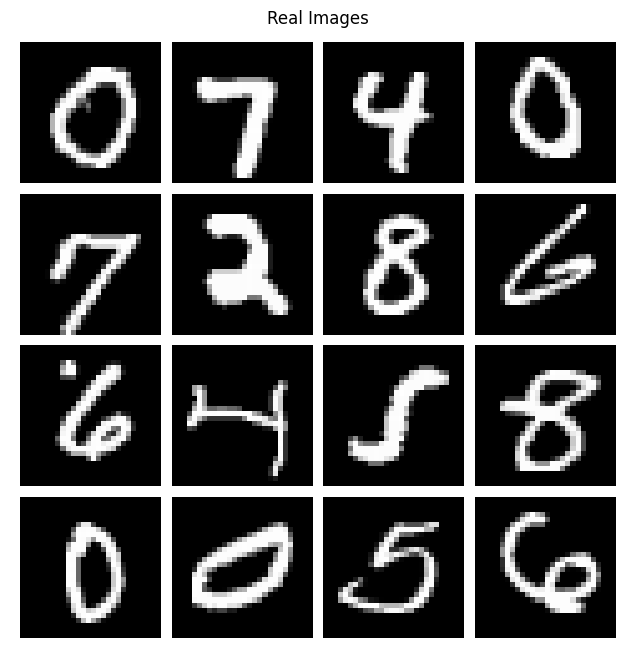

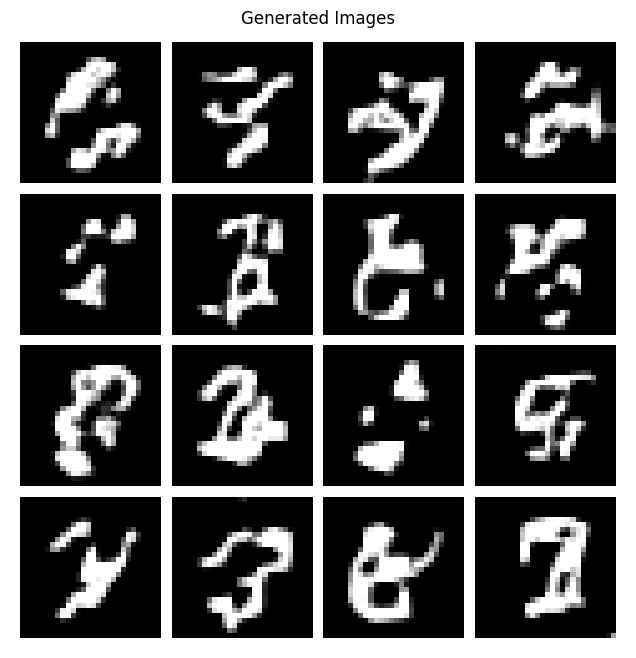

Epoch 13/20: 100%|██████████| 938/938 [01:37<00:00,  9.65it/s, loss=-5.32]


Epoch 13: Avg Loss = -3.8080


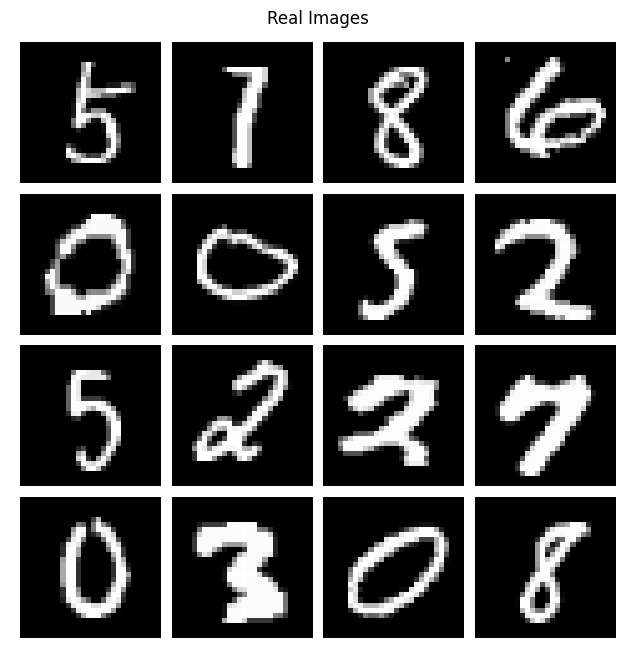

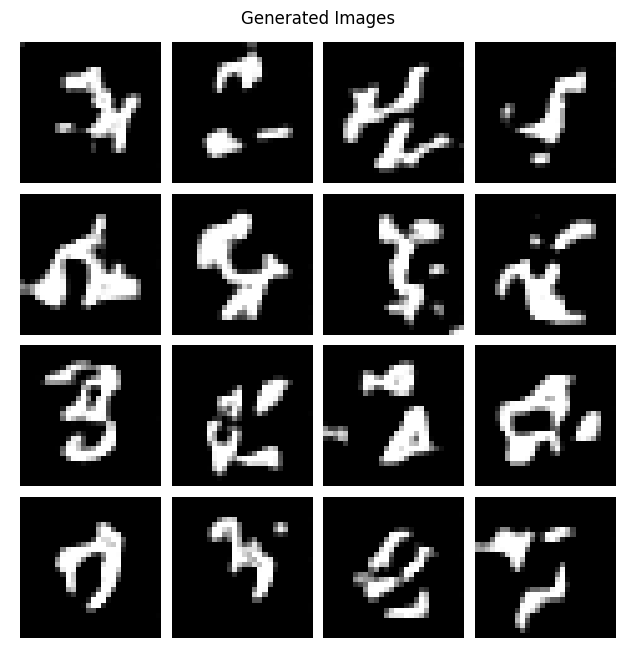

Epoch 14/20: 100%|██████████| 938/938 [01:37<00:00,  9.65it/s, loss=4]


Epoch 14: Avg Loss = -3.9405


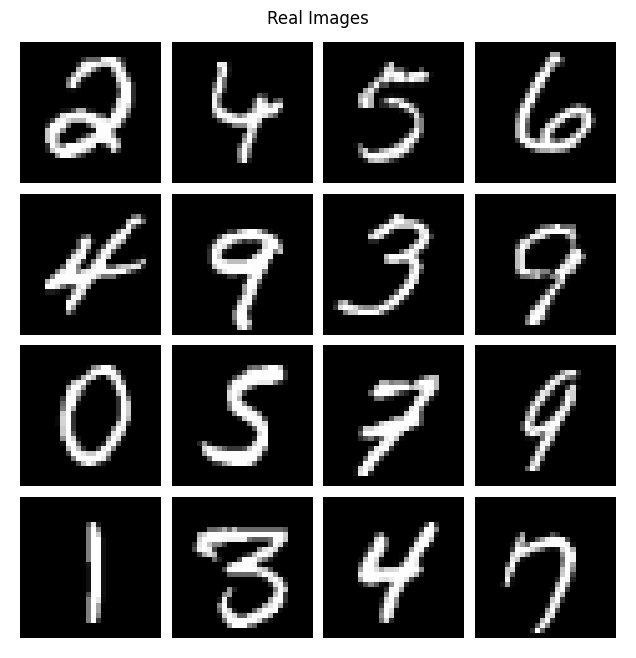

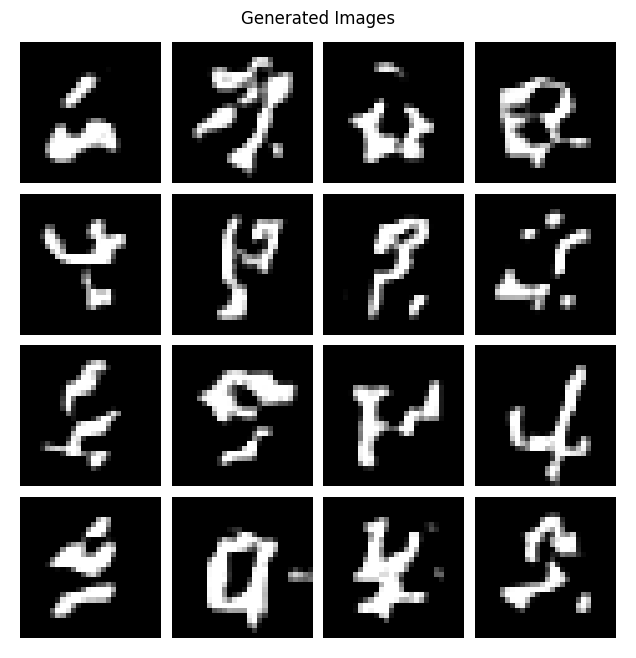

Epoch 15/20: 100%|██████████| 938/938 [01:37<00:00,  9.65it/s, loss=-1.55]


Epoch 15: Avg Loss = -3.8642


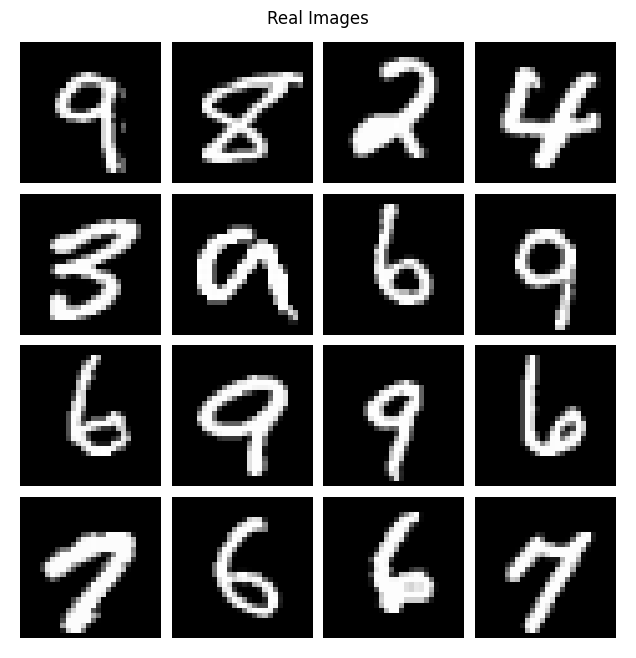

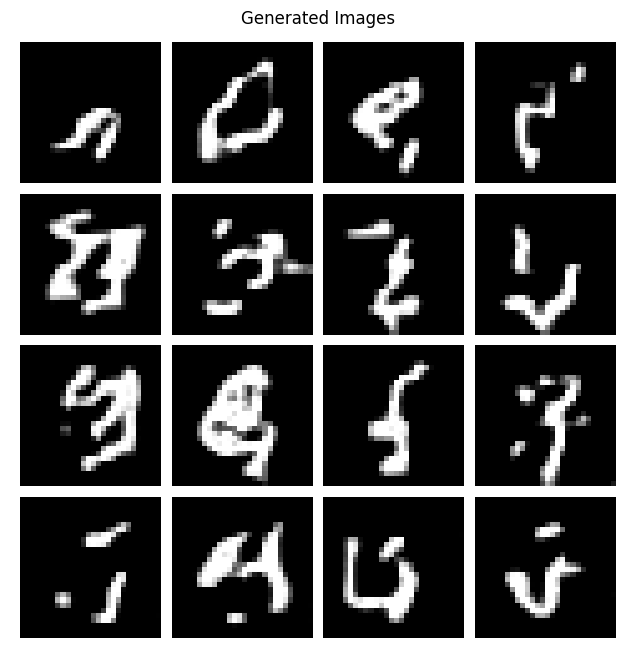

Epoch 16/20: 100%|██████████| 938/938 [01:37<00:00,  9.63it/s, loss=26.8]


Epoch 16: Avg Loss = -3.9784


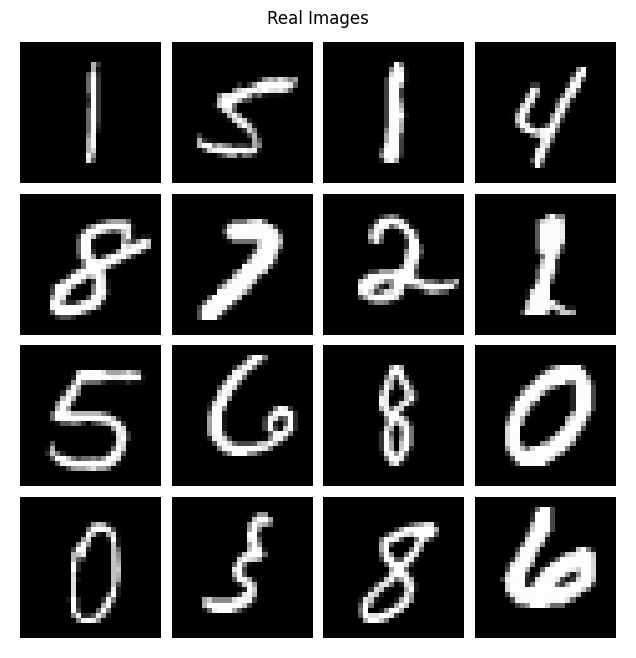

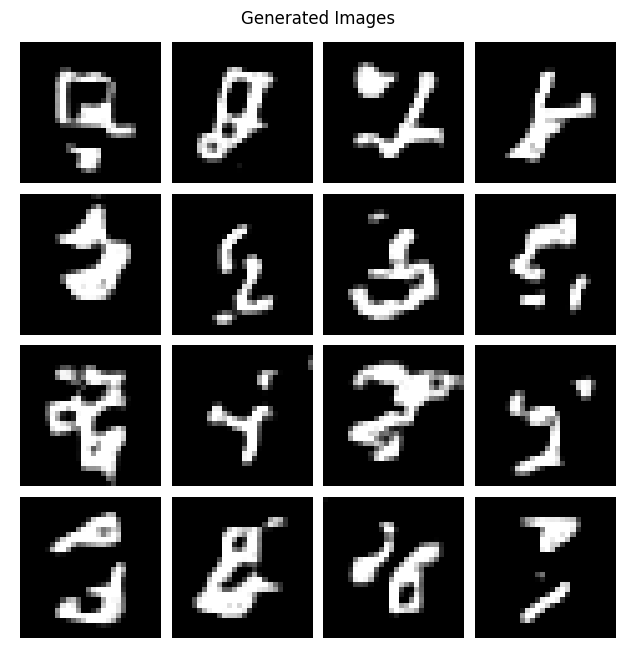

Epoch 17/20: 100%|██████████| 938/938 [01:37<00:00,  9.64it/s, loss=-5.91]


Epoch 17: Avg Loss = -3.9574


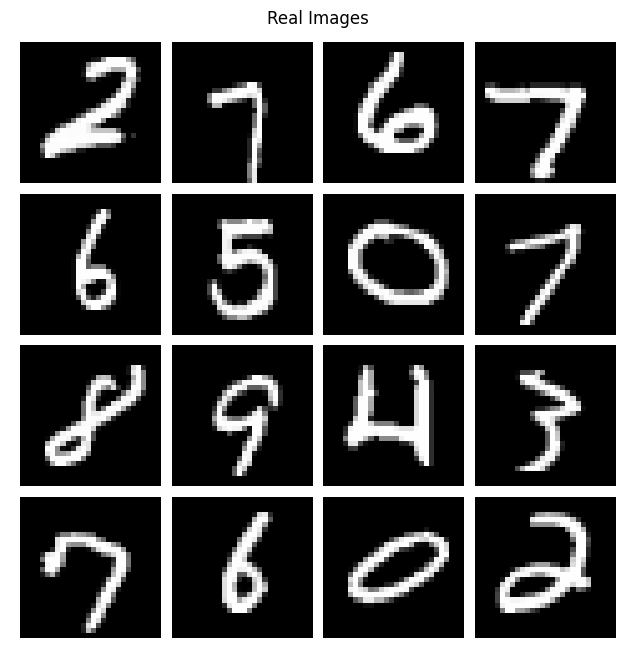

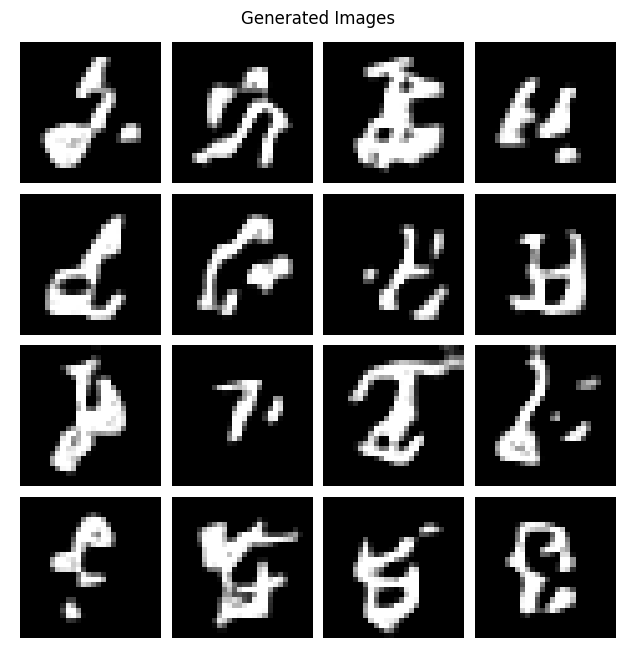

Epoch 18/20: 100%|██████████| 938/938 [01:37<00:00,  9.65it/s, loss=-7.19]


Epoch 18: Avg Loss = -4.0702


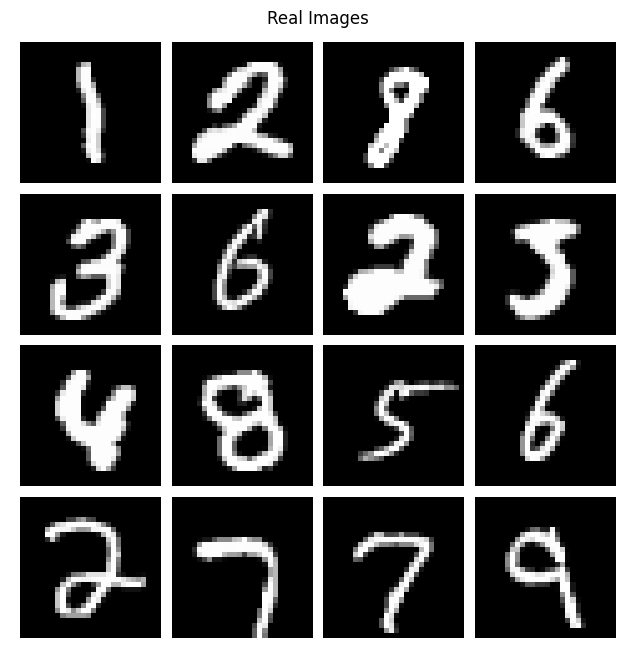

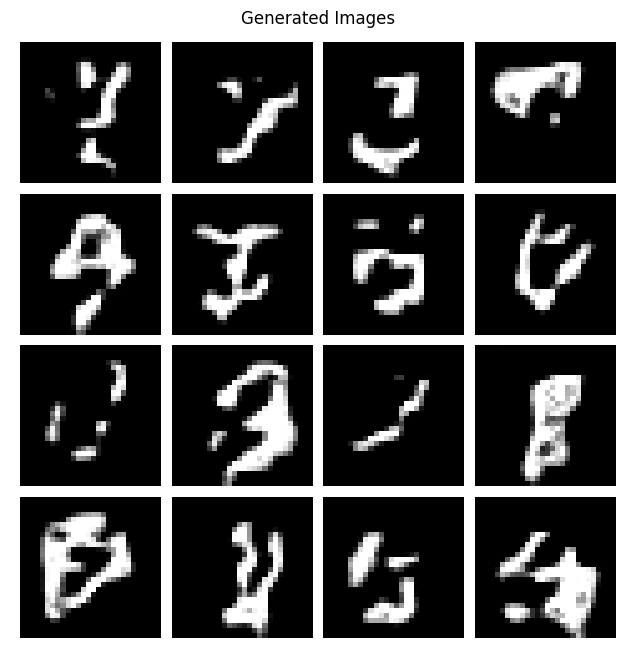

Epoch 19/20: 100%|██████████| 938/938 [01:37<00:00,  9.64it/s, loss=-17.8]


Epoch 19: Avg Loss = -3.9049


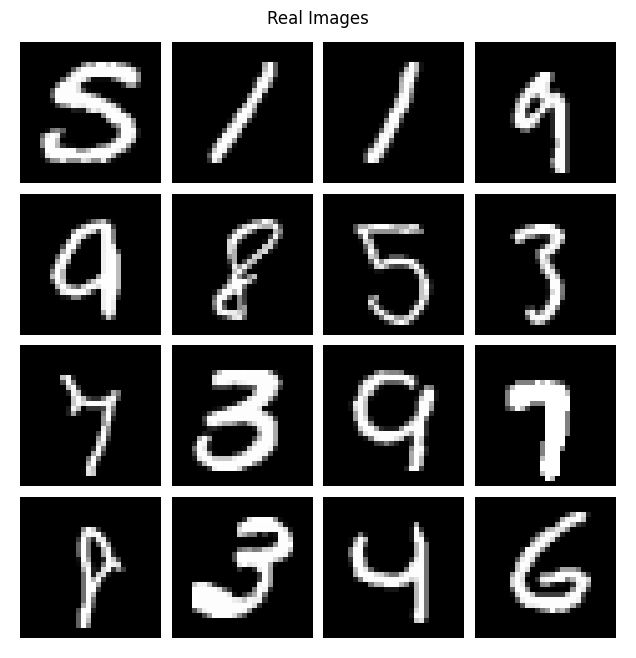

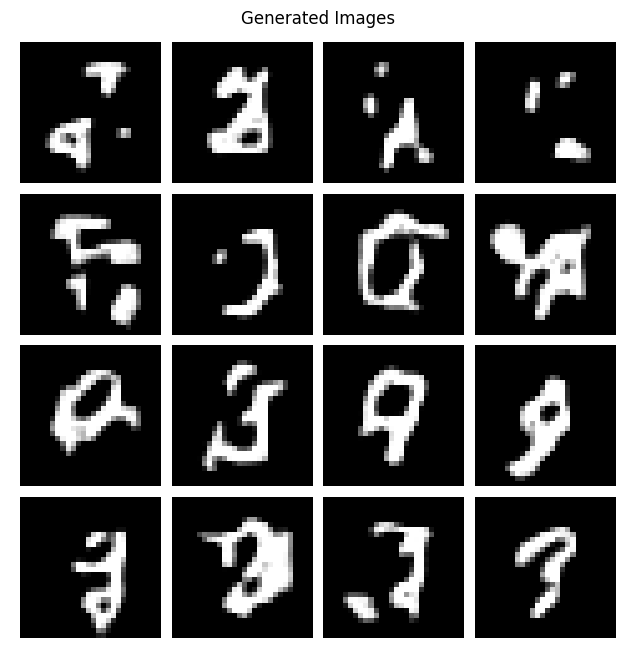

Epoch 20/20: 100%|██████████| 938/938 [01:37<00:00,  9.65it/s, loss=11.4]


Epoch 20: Avg Loss = -4.2695


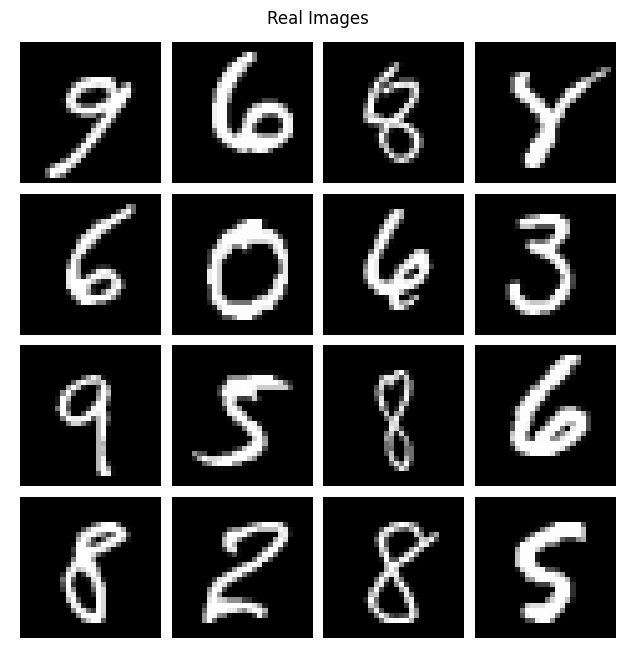

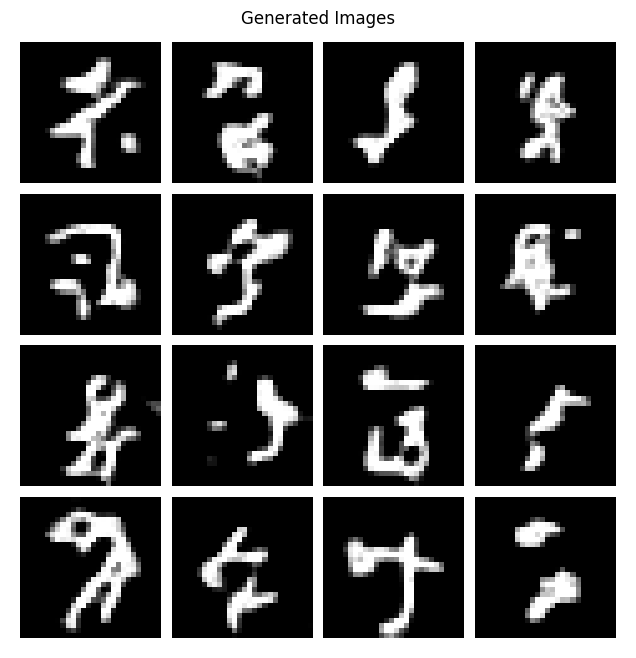

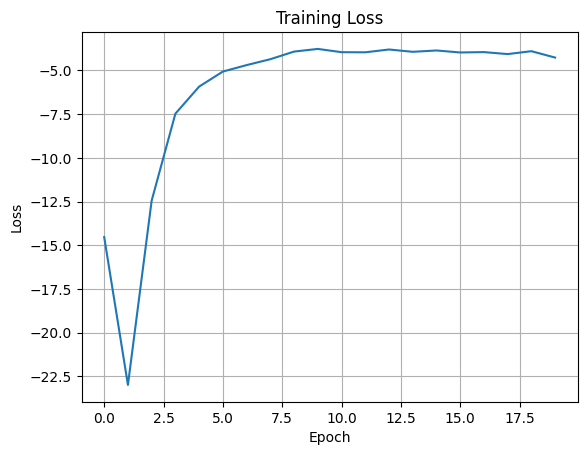

Test Accuracy: 96.96%


In [11]:
def train_ebm(model, optimizer, trainloader, epochs, eta, alpha, sigma):
    loss_history = []
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        progress = tqdm(trainloader, desc=f"Epoch {epoch + 1}/{epochs}")
        for x, y in progress:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = loss_function(model, x, y, eta, alpha, sigma)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            progress.set_postfix(loss=loss.item())
        
        avg_loss = epoch_loss / len(trainloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch + 1}: Avg Loss = {avg_loss:.4f}")

        # Visualize images
        visualize_real(trainloader)
        visualize_generated(model, eta, alpha, sigma)
    
    return loss_history

# Evaluation Function
def evaluate_ebm(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            predictions = logits.argmax(dim=1)
            correct += (predictions == y).sum().item()
            total += y.size(0)
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Main Script
if __name__ == "__main__":
    batch_size = 64
    trainloader, testloader = prepare_data(batch_size)
    
    model = EnergyNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Training Parameters
    epochs = 20
    eta = 50  # Langevin steps
    alpha = 0.01  # Step size
    sigma = 0.01  # Noise scale

    # Train the model
    loss_history = train_ebm(model, optimizer, trainloader, epochs, eta, alpha, sigma)

    # Plot Loss History
    plt.plot(loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)
    plt.show()

    # Evaluate the Model
    evaluate_ebm(model, testloader)